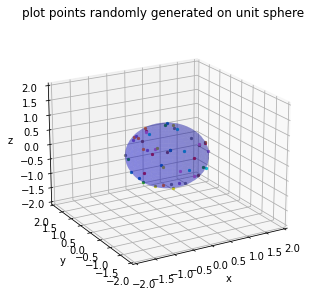

In [1096]:
import numpy as np 
import matplotlib.pyplot as plt 
import colorcet as cc
from math import sqrt
from numpy.linalg import norm 
import matplotlib as mpl 
from mpl_toolkits.mplot3d import Axes3D

def potential_energy(N, X):
    '''
    The potential energy as given by U(e): function
    '''
    U = 0
    # generate random points on the unit sphere
    for i in range(0, N): 
        for j in range(i+1, N):
            r = sqrt((X[i][0] - X[j][0])**2 + (X[i][1] - X[j][1])**2 + (X[i][2] - X[j][2])**2)
            U = U + 1/r
    return 0.5 * U

N = 4
X = np.random.randn(N, 3)
X = X / np.sqrt(np.sum(X**2, axis=1)).reshape(-1, 1) # normalize it 
U = potential_energy(N, X)

# distributing points on the sphere

plt.figure(figsize = (5,5))
ax = plt.axes( projection = '3d')

u = np.linspace(0,2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x,y,z, rstride = 4, cstride=4, color = 'b', alpha = 0.25) 
for i in range(0,N):
    ax.scatter( X[i][0], X[i][1], X[i][2], marker= ".") #100 levels

plt.title('plot points randomly generated on unit sphere') 
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z') 

ax.view_init(20,240) 

In [1097]:
# Defining a bunch of methods including potential energy, gradient of U, PGD, etc etc

def potential_energy(N, X):
    '''
    The potential energy as given by U(e): function
    '''
    U = 0
    # generate random points on the unit sphere
    for i in range(0, N):
        for j in range(i+1, N):
            r = sqrt((X[i][0] - X[j][0])**2 + (X[i][1] - X[j][1])**2 + (X[i][2] - X[j][2])**2)
            if (r == 0):
                r = 1
            U = U + 1/r
    return U * 0.5

#define some methods and stuff

#compute the gradient 
def gradient_U(X, i):
    '''
    gradient of the U function for X
    '''
    grad = np.zeros((3,1))
    
    #gradient for Xi, Yi, and Zi
    Xi_sum = 0 
    Yi_sum = 0 
    Zi_sum = 0 
    for j in range(0, N):
        if (j != i):
            numerator_Xi = X[i][0] - X[j][0]
            numerator_Yi = X[i][1] - X[j][1]
            numerator_Zi = X[i][2] - X[j][2]
            r_3 = sqrt((X[i][0] - X[j][0])**2 + (X[i][1] - X[j][1])**2 + (X[i][2] - X[j][2])**2) ** 3
            Xi_sum += numerator_Xi/r_3
            Yi_sum += numerator_Yi/r_3
            Zi_sum += numerator_Zi/r_3
    grad[0] = Xi_sum
    grad[1] = Yi_sum
    grad[2] = Zi_sum
    return grad 

    
def backtracking(alpha, direction, N, X, i): 
    '''
    Backtracking algorithm where alpha is 1 initially, direction is negative gradient, and X is all the values 
    '''
    X_n = X #define another X in our function 
    
    #Iterate through everything and multiply alpha to it 
    xn = X[i][0]
    yn = X[i][1]
    zn = X[i][2]
    Fn = potential_energy(N, X) # function value of previous iteration
    X_n[i][0] = xn + alpha*direction[0,0]
    X_n[i][1] = yn + alpha*direction[1,0]
    X_n[i][2] = zn + alpha*direction[2,0]
    Fn_1 = potential_energy(N,X_n)

    # While loop to help with our backtracking by comparing Fn values 
    while Fn < Fn_1:
        alpha = beta * alpha 
        X_n[i][0] = xn + alpha*direction[0,0]
        X_n[i][1] = yn + alpha*direction[1,0]
        X_n[i][2] = zn + alpha*direction[2,0]
        Fn_1 = potential_energy(N,X_n)

    #return our alpha value 
    return alpha 
    
def project_Back(x,y,z):
    '''
    Project back to the sphere. If necessary project the free space gradient descent update back to the feasible set
    '''
    norm_free = sqrt( x**2 + y**2 + z**2)
    if (norm_free > 1):
        x, y, z = x/norm_free, y/norm_free, z/norm_free
    return x, y, z


def PGD_for_U(N, X, alpha, i):
    '''
    Projected gradient descent
    '''
    X_n = X
    iteration = 0
    
    x0 = X_n[i][0]
    y0 = X_n[i][1]
    z0 = X_n[i][2] 
    xn_vector = [x0]
    yn_vector = [y0]
    zn_vector = [z0]
    F_vector = [potential_energy(N,X_n)]

    d = -gradient_U(X_n,i)
    alpha = backtracking(alpha, d, N, X_n, i)
    
    xn, yn, zn = x0 + alpha*d[0][0], y0 + alpha*d[1,0], z0 + alpha*d[2, 0]

    compare = [xn, yn, zn]/norm([xn, yn, zn]) - [x0,y0,z0]
    
    X_n[i][0], X_n[i][1], X_n[i][2] = project_Back(xn, yn, zn) 
    xn_vector.append(X_n[i][0]) 
    yn_vector.append(X_n[i][1]) 
    zn_vector.append(X_n[i][2]) 
    F_vector.append(potential_energy(N,X_n))
    
    iteration += 1
    while ( norm(compare) >= tol and iteration < maxIter ): 
        d = -gradient_U(X_n, i)
        alpha = backtracking(alpha, d, N, X_n, i)
        xn, yn, zn = X_n[i][0] + alpha*d[0,0], X_n[i][1] + alpha*d[1, 0], X_n[i][2] + alpha*d[2, 0]

        compare = [xn, yn, zn]/norm([xn, yn, zn]) - [X_n[i][0],X_n[i][1],X_n[i][2]]
        X_n[i][0],X_n[i][1],X_n[i][2] = project_Back(xn, yn, zn) 

        xn_vector.append(X_n[i][0]) 
        yn_vector.append(X_n[i][1]) 
        zn_vector.append(X_n[i][2]) 
        F_vector.append(potential_energy(N,X_n))
        iteration += 1
        
    return X_n, xn_vector, yn_vector, zn_vector, F_vector,iteration 

In [1098]:
# Change the N here to test my code: 
N = 17
# Change the N here to test my code


M = N

#defining a couple variables for our PGD
maxIter = 50 
tol = 1e-4
alpha0 = 1
beta0 = 0.9 #less than 1

X = np.random.randn(N, 3)
X = X / np.sqrt(np.sum(X**2, axis=1)).reshape(-1, 1) # normalize it 

U = potential_energy(N, X)
X_n = X
iteration = 0 

#run the gradient descents. 
for i in range(0,N):
    X_n, xn_vector, yn_vector, zn_vector, F_vector, iteration = PGD_for_U(N, X_n, alpha0, i)

print("Final X Values", X_n)
print("Iterations", iteration) 
print("F_vector for N =",N," ", F_vector[-1])

Final X Values [[-0.34619167  0.83412729 -0.4293984 ]
 [-0.51998622  0.76519292 -0.37959731]
 [ 0.24557236 -0.95389186  0.17258195]
 [ 0.2547571   0.55621464  0.79102724]
 [ 0.93731223  0.03138235  0.34707481]
 [ 0.0442339   0.77486303  0.63057961]
 [ 0.25594056 -0.05973554  0.96484511]
 [ 0.66719154  0.35168167  0.65663952]
 [-0.50613671 -0.59643419 -0.62297022]
 [ 0.45312895 -0.59086901  0.6674938 ]
 [-0.83560865  0.34499655  0.42747581]
 [-0.68798374  0.32127167 -0.65074026]
 [-0.88106747  0.35810615 -0.30899855]
 [-0.25499351 -0.21812892  0.94201809]
 [-0.42001079  0.62170874  0.66111208]
 [ 0.77180555  0.0707825  -0.63190667]
 [-0.58634276 -0.63410318  0.50409852]]
Iterations 50
F_vector for N = 17   61.283477464987094


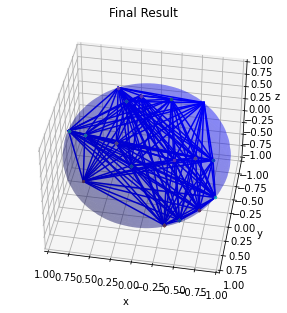

In [1099]:
plt.figure(figsize = (5,5))
ax = plt.axes( projection = '3d')
u = np.linspace(0,2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x,y,z, rstride = 4, cstride=4, color = 'b', alpha = 0.25) 

for i in range(0,N):
    for j in range(i+1, N):
        ax.plot3D([X_n[i][0],X_n[j][0]], [X_n[i][1],X_n[j][1]], [X_n[i][2],X_n[j][2]],'b')
        ax.scatter( X_n[i][0], X_n[i][1], X_n[i][2], marker= ".") #100 levels        
        
plt.title('Final Result') 
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z') 

ax.view_init(40,100) 

Text(0, 0.5, 'U')

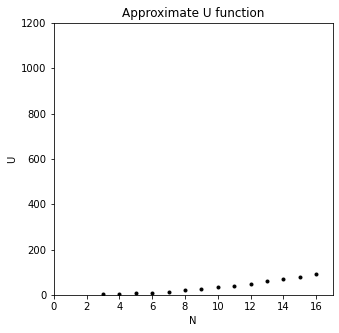

In [1100]:
# 3). 
#begin our plotting with the approximating function 

def U_approx(N):
    a = 1.10461
    b = 0.137
    return (N**2) * 0.5 * (1 - a*N**(-0.5) + b*N**(-1.5))

# define the number of points we need to graph: 


plt.figure(figsize = (5,5))

for i in range(3,N):
    plt.plot(i, U_approx(i), marker = '.', linewidth = 1, c = 'black')
    
plt.xlim(0,N)
plt.ylim(0,1200)
plt.title('Approximate U function')
plt.xlabel('N')
plt.ylabel('U')

In [1101]:
# Generate a bunch of points to test 


# ----------
# (NOTE PLEASE READ!!!!!: 
# if you get a divide by 0 error, please run this block again. It does it sometimes and I'm pretty sure it's 
# just wonky python floating point rounding stuff)
# ----------

F_values = []

for i in range(3,N):
    maxIter = 50 
    tol = 1e-4
    alpha0 = 1
    beta0 = 0.9 #less than 1

    N = 3
    X = np.random.randn(i, 3)
    X = X / np.sqrt(np.sum(X**2, axis=1)).reshape(-1, 1) # normalize it 

    U = potential_energy(i, X)
    X_n = X
    iteration = 0 

    #for use 
    for j in range(0,i):
        X_n, xn_vector, yn_vector, zn_vector, F_vector, iteration = PGD_for_U(i, X_n, alpha0, j)
    print("F_vector for N =", i, " " ,F_vector[-1])
    F_values.append(F_vector[-1])


F_vector for N = 3   1.1281554513094847
F_vector for N = 4   2.321524531355357
F_vector for N = 5   3.692769538876431
F_vector for N = 6   5.446696005519224
F_vector for N = 7   8.093156473224425
F_vector for N = 8   10.253809684074097
F_vector for N = 9   13.842361729173
F_vector for N = 10   17.340794076077337
F_vector for N = 11   21.90864844617878
F_vector for N = 12   30.12622490034378
F_vector for N = 13   33.4318929758644
F_vector for N = 14   51.19039568028007
F_vector for N = 15   44.39181695967256
F_vector for N = 16   50.138084096274675


Text(0, 0.5, 'U')

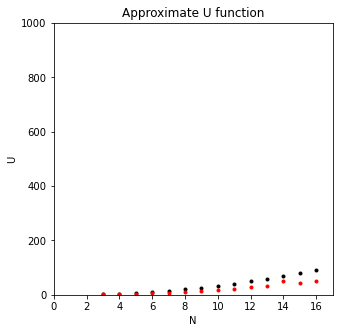

In [1102]:
#plot our findings 
#if graph doesn't show up please add a "N = " here

plt.figure(figsize = (5,5))

for i in range(3,M):
    plt.plot(i, U_approx(i), marker = '.', linewidth = 1, c = 'black')
    plt.plot(i, F_values[i-3], marker = '.', linewidth = 1, c = 'r')
    
plt.xlim(0,M)
plt.ylim(0,1000)
plt.title('Approximate U function')
plt.xlabel('N')
plt.ylabel('U')